# Import libraries


In [6]:
import pandas as pd
import numpy as np
import zipfile
import os
from collections import Counter
from itertools import chain

import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

import torch
from torch.nn.utils.rnn import pad_sequence
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torch.multiprocessing as mp

import gensim.downloader as api

# from google.colab import drive

import pickle

import matplotlib.pyplot as plt


In [7]:
torch.__version__

'2.2.0'

# Load the dataset


In [8]:
# Mount Google Drive
#drive.mount('/content/drive')



In [9]:
# zip_file_path = 'D:\isfahan_ university\Simister 8\NLP\HW 3\HW3-1403/sentiment140.zip'

# unzip_dir = '/content/unzipped_files'
# os.makedirs(unzip_dir, exist_ok=True)

# with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
#     zip_ref.extractall(unzip_dir)


# 1) Preprocessing



In [10]:
# Ensure GPU is used if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Set the start method for multiprocessing
mp.set_start_method('spawn', force=True)


## 1-1 Change the label of positive tweets to 1 and the label of negative tweets to 0.

In [11]:
# Load the dataset in chunks
chunk_size = 5000
chunks = []
for chunk in pd.read_csv('D:/isfahan_ university/Simister 8/NLP/HW 3/HW3-1403/sentiment140.csv', encoding='latin-1', chunksize=chunk_size):
    chunk.columns = ['text', 'date', 'user', 'sentiment', 'query']
    chunk = chunk[['text', 'sentiment']]
    chunk['sentiment'] = chunk['sentiment'].replace({4: 1, 0: 0})
    chunks.append(chunk)

df = pd.concat(chunks)


In [12]:
# Use only 50% of the dataset
df = df.sample(frac=0.5, random_state=42).reset_index(drop=True)


## 1-2 Replace URLs with 'URL' token, mentions with 'MENTION' token and hashtags with 'HASHTAG' token.


## 1-3, 1-4, 1-5
## Remove the punctuation marks.
##  Token each tweet to its words.
##  Perform the lemmatization operation.


In [13]:
nltk.download('punkt')
nltk.download('wordnet')
lemmatizer = WordNetLemmatizer()


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\aminm\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\aminm\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [14]:
def preprocess_text(text):
    text = re.sub(r"http\S+|www\S+|https\S+", 'URL', text, flags=re.MULTILINE)
    text = re.sub(r'\@\w+', 'MENTION', text)
    text = re.sub(r'\#\w+', 'HASHTAG', text)
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    return nltk.word_tokenize(text)


In [15]:
def preprocess_chunk(chunk):
    chunk['text'] = chunk['text'].apply(preprocess_text)
    chunk['text'] = chunk['text'].apply(lambda x: [lemmatizer.lemmatize(word) for word in x])
    return chunk


In [16]:
# Apply preprocessing in chunks
processed_chunks = [preprocess_chunk(chunk) for chunk in np.array_split(df, len(df) // chunk_size)]
df = pd.concat(processed_chunks)


c:\Users\aminm\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


## 1-6 Display the first 20 tweets.


In [17]:
print(df.head(20))


                                                 text  sentiment
0                  [MENTION, AHHH, I, HOPE, YOUR, OK]          0
1   [MENTION, cool, i, have, no, tweet, apps, for,...          0
2   [MENTION, i, know, just, family, drama, it, la...          0
3   [School, email, wont, open, and, I, have, geog...          0
4                            [upper, airway, problem]          0
5       [Going, to, miss, Pastors, sermon, on, Faith]          0
6          [on, lunchdj, should, come, eat, with, me]          1
7   [MENTION, oh, why, are, you, feeling, like, that]          0
8   [gahh, noopeyton, need, to, livethis, is, horr...          0
9   [MENTION, thank, you, glad, you, like, it, The...          1
10  [MENTION, Zach, make, me, pee, sitting, down, ...          1
11    [to, sum, up, my, day, in, one, word, kackered]          1
12               [MENTION, Great, mind, think, alike]          1
13                         [Is, Poorly, and, in, bed]          0
14  [MENTION, Oh, thats, 

## 1-7 Consider 80% of the dataset for training and the remaining 20% for testing.


In [18]:
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)


In [19]:
# Display the shapes of the datasets
print(f"Training set shape: {train_df.shape}")
print(f"Testing set shape: {test_df.shape}")

# Save preprocessed data to CSV
train_df.to_csv('train_data.csv', index=False)
test_df.to_csv('test_data.csv', index=False)


Training set shape: (640000, 2)
Testing set shape: (160000, 2)


# 2) Text Vectorization and Padding


In [20]:
# Parameters
hidden_dim = 200
output_dim = 1
batch_size = 512
epochs = 5
embedding_dim = 300


In [21]:
# Build vocabulary
vocab = Counter(chain(*train_df['text']))
vocab = {word: idx + 1 for idx, (word, _) in enumerate(vocab.items())}


## 2-1, 2-2
## Assign a unique number to each unique word
## Pad sequences

In [22]:
# Function to convert words to indices
def text_to_sequence(text, vocab):
    return [vocab.get(word, 0) for word in text]


In [23]:
# Dataset class
class TextDataset(Dataset):
    def __init__(self, df, vocab):
        self.texts = df['text'].apply(lambda x: text_to_sequence(x, vocab)).tolist()
        self.labels = df['sentiment'].tolist()

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        return torch.tensor(self.texts[idx], dtype=torch.long), torch.tensor(self.labels[idx], dtype=torch.float32)


In [24]:
# Custom collate function to pad sequences within each batch
def collate_fn(batch):
    texts, labels = zip(*batch)
    texts_padded = pad_sequence(texts, batch_first=True, padding_value=0)
    labels = torch.tensor(labels, dtype=torch.float32)
    return texts_padded.to(device), labels.to(device)


In [25]:
# Create Datasets
train_dataset = TextDataset(train_df, vocab)
test_dataset = TextDataset(test_df, vocab)

# Create DataLoaders with custom collate function
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn, pin_memory=True)


# 3) Word Embedding

In [26]:
# Load Google News Word2Vec model
w2v = api.load('word2vec-google-news-300')


In [27]:
# Initialize the embedding matrix
embedding_matrix = np.zeros((len(vocab) + 1, embedding_dim))

for word, idx in vocab.items():
    if word in w2v:
        embedding_matrix[idx] = w2v[word]
    else:
        # Initialize a random vector if the word is not in Word2Vec
        embedding_matrix[idx] = np.random.normal(size=(embedding_dim,))

# Convert embedding matrix to a tensor
embedding_matrix = torch.tensor(embedding_matrix, dtype=torch.float32).to(device)


# 4) Define the RNN model, Training and Testing

In [28]:
class RNNModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, embedding_matrix, hidden_dim, output_dim):
        super(RNNModel, self).__init__()
        self.embedding = nn.Embedding.from_pretrained(embedding_matrix, freeze=False)
        self.rnn = nn.RNN(embedding_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        embedded = self.embedding(x)
        output, hidden = self.rnn(embedded)
        hidden = hidden[-1]
        output = self.fc(hidden)
        return self.sigmoid(output)


## 4-1

In [29]:
# Initialize the model, criterion, and optimizer
model = RNNModel(len(vocab) + 1, embedding_dim, embedding_matrix, hidden_dim, output_dim).to(device)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters())

# Mixed precision training
scaler = torch.cuda.amp.GradScaler()


c:\Users\aminm\anaconda3\Lib\site-packages\torch\cuda\amp\grad_scaler.py:126: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


In [30]:
train_losses = []

# Training loop
for epoch in range(epochs):
    model.train()
    epoch_loss = 0
    for texts, labels in train_loader:
        optimizer.zero_grad()
        with torch.cuda.amp.autocast():  # Mixed precision
            predictions = model(texts).squeeze()
            loss = criterion(predictions, labels)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        epoch_loss += loss.item()

    train_losses.append(epoch_loss)
    print(f'Epoch {epoch+1}, Loss: {epoch_loss/len(train_loader)}')


c:\Users\aminm\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Epoch 1, Loss: 0.46487072269916535
Epoch 2, Loss: 0.3758363874435425
Epoch 3, Loss: 0.3138071233868599
Epoch 4, Loss: 0.25167330372333524
Epoch 5, Loss: 0.20004773244857788


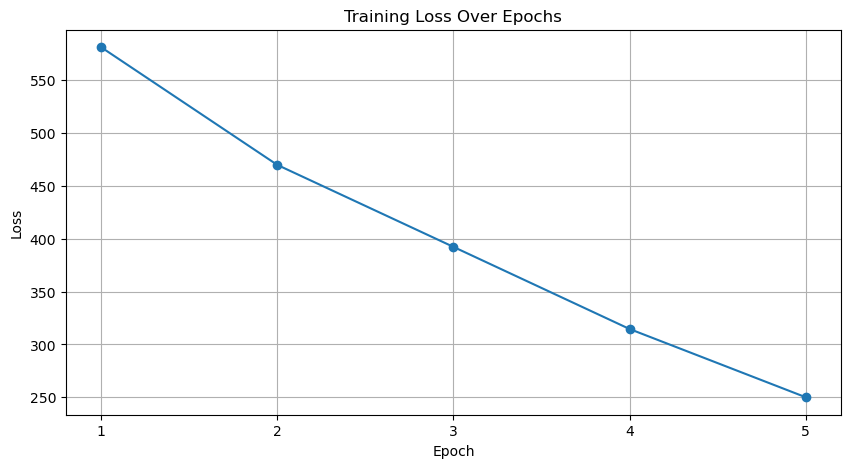

In [31]:
# Plot training loss
plt.figure(figsize=(10, 5))
plt.plot(range(1, epochs + 1), train_losses, marker='o')
plt.title('Training Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.xticks(range(1, epochs + 1))
plt.grid(True)
plt.show()


In [32]:
# Save the model
torch.save(model.state_dict(), 'rnn_model.pth')


## 4-2 Evaluation


In [33]:
model.eval()
test_loss = 0
predictions = []
with torch.no_grad():
    for batch in test_loader:
        texts, labels = batch
        preds = model(texts).squeeze()
        loss = criterion(preds, labels)
        test_loss += loss.item()
        predictions.extend((preds > 0.5).int().tolist())

print(f"Test Loss: {test_loss/len(test_loader)}")


Test Loss: 0.5507221936989135


In [34]:
# Generate a classification report
test_labels_list = [label.item() for _, label in test_dataset]
print(classification_report(test_labels_list, predictions, target_names=['Negative', 'Positive']))


              precision    recall  f1-score   support

    Negative       0.78      0.83      0.81     79976
    Positive       0.82      0.77      0.80     80024

    accuracy                           0.80    160000
   macro avg       0.80      0.80      0.80    160000
weighted avg       0.80      0.80      0.80    160000

